# Organizing Ultrasound Imaging Data for Enhanced Breast Cancer Diagnosis with Deep Learning Models

### Importing required libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToPILImage
from torchvision import transforms
from PIL import Image
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
import numpy as np
import pytesseract
from torchvision import datasets
import random
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import re
from sklearn.model_selection import train_test_split
import json

### Reading the files

In [3]:
# input and output
#input_folder = r"H:\My Drive\chen_ellis_mayo_project\BUS Project Home\Datasets\Mayo\Mayo Downloads\bus_2018-19"
input_folder = r"C:\Users\prana"
# database json file
#db_json_file = input_folder + r"\database.json"
db_json_file = input_folder + r"\database.json"

In [6]:
# helper function for assigning biopsy labels

benign_labels = ['Pathology Benign','Benign','Pathology Elevated Risk']
malignant_labels = ['Pathology Malignant','Malignant']

def biopsy_labeler(raw_label, b_labels = benign_labels, m_labels = malignant_labels):
    if raw_label in b_labels:
        label = 'benign'
    elif raw_label in m_labels:
        label = 'malignant'
    else:
        label = 'unknown'
    return label

In [7]:
# function to convert id to image filename
def image_id_to_filename( image_id ):
    return f'{image_id:06d}_cropped.png'    

In [8]:
def df_parser( db_json_file, missing_value = None ):
    
    # open, read, and close json file
    f = open(db_json_file)
    data = json.load(f)
    f.close()
    
    results_dict = {}
    for patient in data:
        patient_id = patient['anonymized_accession_num']
        biopsy = biopsy_labeler( patient['biopsy'] )
        birads = patient['birads']
        for image in patient['dicoms']:
            image_id = int(image['id'])
            filename = image_id_to_filename( image_id )
            metadata = image['metadata']
            patient_size = metadata.get('PatientSize',missing_value)
            patient_weight = metadata.get('PatientWeight',missing_value)
            us_region = metadata['SequenceOfUltrasoundRegions'][0]
            us_x0 = us_region['RegionLocationMinX0']
            us_y0 = us_region['RegionLocationMinY0']
            us_x1 = us_region['RegionLocationMaxX1']
            us_y1 = us_region['RegionLocationMaxY1']
            delta_x = us_region['PhysicalDeltaX']
            delta_y = us_region['PhysicalDeltaY']
            image_type = metadata['PhotometricInterpretation'] #MONCHROME2 or RGB
            study_date = metadata['StudyDate']
            study_description = metadata['StudyDescription']
            row_dict = {'patient_id':patient_id,
                        'biopsy':biopsy,
                        'birads':birads,
                        'filename':filename,
                        'patient_size':patient_size,
                        'patient_weight':patient_weight,
                        'us_x0':us_x0,
                        'us_y0':us_y0,
                        'us_x1':us_x1,
                        'us_y1':us_y1,
                        'delta_x': delta_x,
                        'delta_y': delta_y,
                        'image_type':image_type,
                        'study_date':study_date,
                        'study_description':study_description}
            results_dict[image_id] = row_dict

    df = pd.DataFrame.from_dict(results_dict,orient='index')
    df.reset_index(inplace=True)
    df.rename(columns = {'index':'image_id'},inplace=True)
    df.sort_values(by = ['patient_id', 'image_id'],inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns=['index'],inplace=True)
    return df

In [9]:
df = df_parser(db_json_file)
df

,image_id,patient_id,biopsy,birads,filename,patient_size,patient_weight,us_x0,us_y0,us_x1,us_y1,delta_x,delta_y,image_type,study_date,study_description
0,1,3,malignant,5,000001_cropped.png,1.63,139.8,2,101,853,665,0.008850,0.008850,MONOCHROME2,20181115,BI ULTRASOUND BREAST FOCUSED RIGHT
1,2,3,malignant,5,000002_cropped.png,1.63,139.8,2,101,853,665,0.009052,0.009052,RGB,20181115,BI ULTRASOUND BREAST FOCUSED RIGHT
2,3,3,malignant,5,000003_cropped.png,1.63,139.8,2,101,853,665,0.007965,0.007965,MONOCHROME2,20181115,BI ULTRASOUND BREAST FOCUSED RIGHT
3,4,3,malignant,5,000004_cropped.png,1.63,139.8,2,101,853,665,0.007965,0.007965,MONOCHROME2,20181115,BI ULTRASOUND BREAST FOCUSED RIGHT
4,5,3,malignant,5,000005_cropped.png,1.63,139.8,2,101,853,665,0.008850,0.008850,RGB,20181115,BI ULTRASOUND BREAST FOCUSED RIGHT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4093,4094,363,malignant,5,004094_cropped.png,1.61,63.1,2,101,853,665,0.008216,0.008216,MONOCHROME2,20191016,BI ULTRASOUND BREAST FOCUSED LEFT
4094,4095,364,unknown,6,004095_cropped.png,1.59,62.7,2,101,853,665,0.004425,0.004425,MONOCHROME2,20191101,BI ULTRASOUND BREAST FOCUSED RIGHT
4095,4096,364,unknown,6,004096_cropped.png,1.59,62.7,2,101,853,665,0.004425,0.004425,MONOCHROME2,20191101,BI ULTRASOUND BREAST FOCUSED RIGHT
4096,4097,364,unknown,6,004097_cropped.png,1.59,62.7,2,101,853,665,0.004425,0.004425,MONOCHROME2,20191101,BI ULTRASOUND BREAST FOCUSED RIGHT


In [10]:
np.random.seed(124)

# Define the range and the number of samples
low = 20
high = 80

# Generate random numbers with a triangular distribution around 55
mode = 55
random_numbers = np.random.triangular(low, mode, high, size=len(df)).astype(int)

# Assign the random numbers to the 'patientAge' column
df['patientAge'] = random_numbers


In [11]:
#randomly assign mammographic breast density
breastDensity = ['A', 'B', 'C', 'D']
df['mammographicBD'] = np.random.choice(breastDensity, size=len(df))

#List of names
mType = ['S1000', 'S3000', 'Xario', 'Affiniti', 'LOGIQ5', 'LOGIQ7', 'LOGIQ9']
# Randomly assign names to the dataframe
df['machineType'] = np.random.choice(mType, size=len(df))


bilateral_labels = ['BI ULTRASOUND BREAST FOCUSED BILATERAL', 'BI ULTRASOUND BREAST BILATERAL' ]
left_labels = ['BI ULTRASOUND BREAST FOCUSED LEFT', 'BI ULTRASOUND BREAST LEFT']
right_labels = ['BI ULTRASOUND BREAST FOCUSED RIGHT', 'BI ULTRASOUND BREAST RIGHT']

def study_description_labeler(raw_labels, b_labels = bilateral_labels, l_labels = left_labels, r_labels = right_labels):
    if raw_labels in b_labels:
        label = 'bilateral'
    elif raw_labels in l_labels:
        label = 'left'
    elif raw_labels in r_labels:
        label = 'right'
    else:
        label = 'unknown'
    return label
# Assume the existing column is called 'StudyDescription'
df['study_descriptions'] = df['study_description'].apply(lambda x: study_description_labeler(x))
del df['study_description']

In [12]:
df[0:10]

,image_id,patient_id,biopsy,birads,filename,patient_size,patient_weight,us_x0,us_y0,us_x1,us_y1,delta_x,delta_y,image_type,study_date,patientAge,mammographicBD,machineType,study_descriptions
0,1,3,malignant,5,000001_cropped.png,1.63,139.8,2,101,853,665,0.008850,0.008850,MONOCHROME2,20181115,34,C,LOGIQ5,right
1,2,3,malignant,5,000002_cropped.png,1.63,139.8,2,101,853,665,0.009052,0.009052,RGB,20181115,60,B,S3000,right
2,3,3,malignant,5,000003_cropped.png,1.63,139.8,2,101,853,665,0.007965,0.007965,MONOCHROME2,20181115,54,A,LOGIQ7,right
3,4,3,malignant,5,000004_cropped.png,1.63,139.8,2,101,853,665,0.007965,0.007965,MONOCHROME2,20181115,51,D,Affiniti,right
4,5,3,malignant,5,000005_cropped.png,1.63,139.8,2,101,853,665,0.008850,0.008850,RGB,20181115,48,B,Affiniti,right
5,6,3,malignant,5,000006_cropped.png,1.63,139.8,2,101,853,665,0.008850,0.008850,MONOCHROME2,20181115,43,C,S1000,right
6,7,3,malignant,5,000007_cropped.png,1.63,139.8,2,101,853,665,0.008850,0.008850,MONOCHROME2,20181115,57,D,S1000,right
7,8,3,malignant,5,000008_cropped.png,1.63,139.8,2,101,853,665,0.008850,0.008850,RGB,20181115,48,B,LOGIQ9,right
8,9,3,malignant,5,000009_cropped.png,1.63,139.8,2,101,853,665,0.007965,0.007965,RGB,20181115,44,B,LOGIQ5,right
9,10,3,malignant,5,000010_cropped.png,1.63,139.8,2,101,853,665,0.008850,0.008850,MONOCHROME2,20181115,61,D,LOGIQ5,right


### Text extraction from ultrasound images

In [13]:
#text extraction function
def extract_text_from_images(folder_path):
    # Defining path to tesseract.exe
    path_to_tesseract = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    #path_to_tesseract = r"C:\Users\jbaggett\Anaconda3\envs\fastai3\Library\bin\tesseract.exe"
  
    # Providing the tesseract executable location to pytesseract library
    pytesseract.tesseract_cmd = path_to_tesseract

    # Initialize an empty list to store the extracted text and filenames
    text_list = []
    files = os.listdir(folder_path)
    
    # Loop through all the files in the folder
    for file_name in files:
        # Check if the file is an image
        if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Construct the full path to the image file
            image_path = os.path.join(folder_path, file_name)
            
            # Open the image file and store it in an image object
            img = Image.open(image_path)
            
            # recast image as numpy array
            img = np.array(img)
            
            # if image has multiple channels convert it to grayscale (could probably improve this)
            if len(img.shape)>2:
                img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            
            # crop to include only bottom of image
            # note in most images the ultrasound part is between 10 and 665 for the first coord (y), and 2 and 853 for the second coord (x)
            img = img[ 500:, 22:833 ]
            
            # convert to black and white to increase contrast
            threshold = 160
            th,img = cv2.threshold(img,threshold,255,cv2.THRESH_BINARY)
            
            
            # show a dilated image
            #A larger kernel size will result in a more dilated image, which can make it easier to find contours.
            kernel = np.ones((7,7),np.uint8)
            img_dilated = cv2.dilate(img,kernel,iterations=5)
            contours,hierarchy = cv2.findContours(img_dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
            c = max(contours,key=cv2.contourArea)
            x,y,w,h = cv2.boundingRect(c)
            rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
#             fig,ax = plt.subplots()
#             ax.imshow(img_dilated)
#             ax.add_patch(rect)
#             fig.show()

            # Extract the text from the image using pytesseract
            text = pytesseract.image_to_string(img[y:y+h+1,x:x+w+1])
            text = text.replace("\n"," ")
            
            # If the extracted text is empty, try extracting text from the entire image
            if not text or '¢' in text or len(text.split()) == 1:
                text = pytesseract.image_to_string(img)
                text = text.replace("\n"," ")

            # Append the extracted text and filename to the list
            text_list.append((file_name, text[:-1])) # exclude the last character which is usually a newline character
    
    # Create a pandas DataFrame from the text list
    df = pd.DataFrame(text_list, columns=['image_filename', 'text'])
    
    return df

In [14]:
folder_path = r"C:/Users/prana/image"

In [15]:
text_df = extract_text_from_images(folder_path)
text_df.to_csv('textOnly.csv', index=False)

In [19]:
def clean_text(data):
    """
    This function takes a pandas DataFrame column as input, removes noisy data and returns the cleaned text.
    """
    cleaned_data = []
    for text in data:
        text = text.upper()
        if pd.isnull(text):
            # Skip null values
            continue
        
        # Remove newline characters
        text = text.replace('\n', ' ')
        
       # Add space before and after certain vg
    
        text = re.sub(r'(?<![ \t])(TRANS|RADIAL|LONG|RT|LT|ANTI RADIAL|FN)(?![ \t])', r' \1 ', text)
        
        # Remove text after [ or { bracket
        text = re.sub(r'([\[}]).+', r'\1', text)
        text = re.sub(r'(ol|es|on|eer|OL)\b', '', text)
        #text = re.sub(r'1L\d*\.?\d*\b', '', text)
        text = re.sub(r'\d+L.*', '', text)

        
        # Add space after pattern '8:00' or anything in this pattern if not there
        text = re.sub(r'(8:\d\d)(?!\s)', r'\1 ', text)
        
        # Remove noisy data at the end of the text
        text = re.sub(r'\b\d+¢|\b\d+L\b|\b\d+L\s+\d+\s*\b', '', text)
        
        # Extract relevant information
        match = re.search(r'(TRANS|RADIAL|LONG|RT|LT|ANTI RADIAL|OBLIQUE)', text)
        if match:
            text = text[match.start():]
        
        # Remove noisy characters
        cleaned_text = re.sub(r'[^\w\s:-]', '', text)
        
        # Remove extra spaces
        cleaned_text = ' '.join(cleaned_text.split())
       
        # Remove '.' character at the end of the text
        cleaned_text = cleaned_text.rstrip('.')
        
        cleaned_data.append(cleaned_text)
    
    return pd.Series(cleaned_data)


In [20]:
text_df['cleaned_text'] = clean_text(text_df['text'])

### EasyOCR code from google colab

In [ ]:
import pandas as pd
from google.colab import drive
import easyocr

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/textOnly.csv')

# Filter out rows with empty 'text' column
filtered_df = df[df['text'].isnull()]

# Iterate over the filtered DataFrame and retrieve image information
for index, row in filtered_df.iterrows():
    image_name = row['image_filename']
    image_path = '/content/drive/MyDrive/Colab Notebooks/image/' + image_name
    reader = easyocr.Reader(['en'])
    result = reader.readtext(image_path, paragraph=True)
    filtered_df.at[index, 'text'] = result[-1][-1]

# Show the filtered DataFrame
filtered_df.to_csv('FilteredText.csv', index=False)

In [21]:
## As i am not able to use the EasyOCR on my local machone, I am using google colab and generating filtered dataframe there and fectching back to my original notebook
f_df = pd.read_csv('FilteredText.csv')
f_df['text'] = f_df['text'].str.replace(".", ":").str.replace("/", " ")
f_df['cleaned_text'] = clean_text(f_df['text'])
f_df

,image_filename,text,cleaned_text
0,000795_cropped.png,TRANS RT BREAST 10:00 6CM FN,TRANS RT BREAST 10:00 6CM FN
1,000798_cropped.png,TRANS RT BREAST 10:00 6CM FN,TRANS RT BREAST 10:00 6CM FN
2,000802_cropped.png,LONG RT BREAST 10:00 6CM FN |,LONG RT BREAST 10:00 6CM FN
3,000804_cropped.png,LONG RT BREAST 10:00 6CM FN,LONG RT BREAST 10:00 6CM FN
4,000882_cropped.png,LONG RT BREAST 12:00 8CM FN,LONG RT BREAST 12:00 8CM FN
5,000891_cropped.png,11:30 12CM FN PALP,11:30 12CM FN PALP
6,001457_cropped.png,TRANS LT BREAST 10:00 1OCM FN,TRANS LT BREAST 10:00 1OCM FN
7,001615_cropped.png,TRANS LT BREAST 10:00 4CM FN,TRANS LT BREAST 10:00 4CM FN
8,001665_cropped.png,LONG LT BREAST 1:30 7CM FN,LONG LT BREAST 1:30 7CM FN
9,001719_cropped.png,TRANS RT BREAST 1:00 8CM FN,TRANS RT BREAST 1:00 8CM FN


In [22]:
# set col1 as the index for both dataframes
text_df = text_df.set_index('image_filename')
f_df = f_df.set_index('image_filename')

# update the rows in df1 with the corresponding rows in df2
text_df.update(f_df)

# reset the index for df1
text_df = text_df.reset_index()

In [23]:
#frequency analysis
x= text_df['cleaned_text'].value_counts()
x

cleaned_text
LONG LT AXILLA                                   115
LONG RT AXILLA                                    84
LT AXILLA                                         71
TRANS LT AXILLA                                   52
RT AXILLA                                         44
                                                ... 
TRANS LT BREAST 4:00 1CM FN                        1
TRANS LT BREAS 7:00 1CM FN                         1
TRANS RT BREAST 6:30 4CM FN AREA PALPATED OLI      1
LONG LT BREAST 1000 4CM FN                         1
TRANS RT BREAST 9:30 5CM FN                        1
Name: count, Length: 982, dtype: int64

In [24]:
#Accuracy test
# Calculate the percentage of exact matches between the original and cleaned columns
exact_matches = (text_df['text'] == text_df['cleaned_text']).sum()
total_rows = len(text_df)
percentage_exact_matches = exact_matches / total_rows * 100

print(f"Percentage of exact matches PyTesseract and EasyOCR: {(round(percentage_exact_matches))}%")

Percentage of exact matches PyTesseract and EasyOCR: 83%


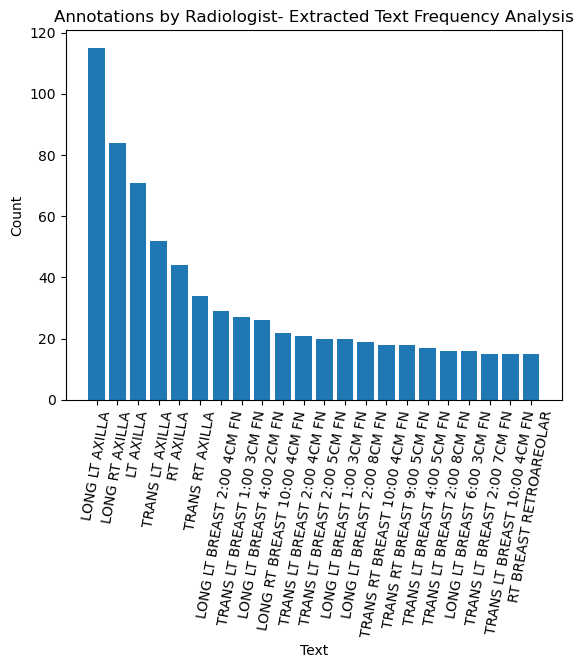

In [25]:
import matplotlib.pyplot as plt

x = text_df['cleaned_text'].value_counts()
x = x[x >= 15]  # filter to only include values up to 15
# Create the bar plot
plt.bar(x.index, x.values)

# Add title and labels
plt.title('Annotations by Radiologist- Extracted Text Frequency Analysis')
plt.xlabel('Text')
plt.ylabel('Count')

# Rotate x-labels by 45 degrees
plt.xticks(rotation= 80)

# Show the plot
plt.show()

In [26]:
# create new columns in the existing dataframe
text_df[['Scanning_Area', 'Location', 'TIME', 'Distance FN']] = pd.DataFrame([['']*4]*len(text_df))

# iterate over each row in the dataframe
for index, row in text_df.iterrows():
    # get the input string from the 'String' column
    input_string = row['cleaned_text']
    
    # split string by space
    split_string = input_string.split()

    # iterate over each word in the split string
    for i, word in enumerate(split_string):
        if 'TRANS' in word or 'LONG' in word or'RADIAL' in word:
            # check if word contains 'TRANS' or 'LONG' or 'RADIAL'
            if i > 0 and split_string[i-1] == 'ANTI':
                text_df.loc[index, 'Scanning_Area'] = 'ANTI RADIAL'
            else:
                text_df.loc[index, 'Scanning_Area'] = word
        elif word == 'LT' or word == 'RT' or word == 'RIGHT' or word == 'LEFT':
            # check if word is 'LT' or 'RT'
            text_df.loc[index, 'Location'] = word
            #resetting distance to empty string to avoid carrying over any potentially incorrect or irrelevant distance values
            text_df.loc[index, 'Distance FN'] = ''
        elif re.match(r'\d{1,2}\s*:\s*\d{2}$', word) and text_df.loc[index, 'TIME'] == '':
            # check if word is a time in the format 'HH:MM' and the 'TIME' column is still empty
            text_df.loc[index, 'TIME'] = word
        elif re.match(r'\d+\.?\d*\s?CM', word):
            # check if word contains a distance in centimeters
            text_df.loc[index, 'Distance FN'] = word

    # use a regular expression to extract the time range
    match = re.search(r'\d+:\d+\s*-\s*\d+:\d+', input_string)
    if match:
        # if a match is found, extract the substring and assign it to the 'TIME' column
        text_df.loc[index, 'TIME'] = match.group()

# display the resulting dataframe
text_df


,image_filename,text,cleaned_text,Scanning_Area,Location,TIME,Distance FN
0,000001_cropped.png,TRANS RT AXILLA,TRANS RT AXILLA,TRANS,RT,,
1,000002_cropped.png,LONG RT BREAST 8:00 5CM FN,LONG RT BREAST 8:00 5CM FN,LONG,RT,8:00,5CM
2,000003_cropped.png,TRANS RT BREAST 8:00 5CM FN,TRANS RT BREAST 8:00 5CM FN,TRANS,RT,8:00,5CM
3,000004_cropped.png,TRANS RT BREAST 8:00 5CM FN,TRANS RT BREAST 8:00 5CM FN,TRANS,RT,8:00,5CM
4,000005_cropped.png,TRANS RT AXILLA,TRANS RT AXILLA,TRANS,RT,,
...,...,...,...,...,...,...,...
4093,004094_cropped.png,LONG LT BREAST 10:00 5CM FN 8:00-10:00 AREA PA...,LONG LT BREAST 10:00 5CM FN 8:00 -10:00 AREA P...,LONG,LT,8:00 -10:00,5CM
4094,004095_cropped.png,LONG LT BREAST 4:00 6CM FN,LONG LT BREAST 4:00 6CM FN,LONG,LT,4:00,6CM
4095,004096_cropped.png,TRANS RT BREAST 9:00 5CM FN,TRANS RT BREAST 9:00 5CM FN,TRANS,RT,9:00,5CM
4096,004097_cropped.png,TRANS RT BREAST 9:30 5CM FN,TRANS RT BREAST 9:30 5CM FN,TRANS,RT,9:30,5CM


In [28]:
merged_df = pd.concat([df,text_df], axis=1)
merged_df

,image_id,patient_id,biopsy,birads,filename,patient_size,patient_weight,us_x0,us_y0,us_x1,...,mammographicBD,machineType,study_descriptions,image_filename,text,cleaned_text,Scanning_Area,Location,TIME,Distance FN
0,1,3,malignant,5,000001_cropped.png,1.63,139.8,2,101,853,...,C,LOGIQ5,right,000001_cropped.png,TRANS RT AXILLA,TRANS RT AXILLA,TRANS,RT,,
1,2,3,malignant,5,000002_cropped.png,1.63,139.8,2,101,853,...,B,S3000,right,000002_cropped.png,LONG RT BREAST 8:00 5CM FN,LONG RT BREAST 8:00 5CM FN,LONG,RT,8:00,5CM
2,3,3,malignant,5,000003_cropped.png,1.63,139.8,2,101,853,...,A,LOGIQ7,right,000003_cropped.png,TRANS RT BREAST 8:00 5CM FN,TRANS RT BREAST 8:00 5CM FN,TRANS,RT,8:00,5CM
3,4,3,malignant,5,000004_cropped.png,1.63,139.8,2,101,853,...,D,Affiniti,right,000004_cropped.png,TRANS RT BREAST 8:00 5CM FN,TRANS RT BREAST 8:00 5CM FN,TRANS,RT,8:00,5CM
4,5,3,malignant,5,000005_cropped.png,1.63,139.8,2,101,853,...,B,Affiniti,right,000005_cropped.png,TRANS RT AXILLA,TRANS RT AXILLA,TRANS,RT,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4093,4094,363,malignant,5,004094_cropped.png,1.61,63.1,2,101,853,...,C,LOGIQ5,left,004094_cropped.png,LONG LT BREAST 10:00 5CM FN 8:00-10:00 AREA PA...,LONG LT BREAST 10:00 5CM FN 8:00 -10:00 AREA P...,LONG,LT,8:00 -10:00,5CM
4094,4095,364,unknown,6,004095_cropped.png,1.59,62.7,2,101,853,...,D,LOGIQ5,right,004095_cropped.png,LONG LT BREAST 4:00 6CM FN,LONG LT BREAST 4:00 6CM FN,LONG,LT,4:00,6CM
4095,4096,364,unknown,6,004096_cropped.png,1.59,62.7,2,101,853,...,B,S3000,right,004096_cropped.png,TRANS RT BREAST 9:00 5CM FN,TRANS RT BREAST 9:00 5CM FN,TRANS,RT,9:00,5CM
4096,4097,364,unknown,6,004097_cropped.png,1.59,62.7,2,101,853,...,A,Affiniti,right,004097_cropped.png,TRANS RT BREAST 9:30 5CM FN,TRANS RT BREAST 9:30 5CM FN,TRANS,RT,9:30,5CM


### Organized dataset

In [29]:
merged_df.to_csv('organized_db.csv', index=False)

In [30]:
merged_df.columns

Index(['image_id', 'patient_id', 'biopsy', 'birads', 'filename',
       'patient_size', 'patient_weight', 'us_x0', 'us_y0', 'us_x1', 'us_y1',
       'delta_x', 'delta_y', 'image_type', 'study_date', 'patientAge',
       'mammographicBD', 'machineType', 'study_descriptions', 'image_filename',
       'text', 'cleaned_text', 'Scanning_Area', 'Location', 'TIME',
       'Distance FN'],
      dtype='object')

In [88]:
### Splitting datset 60% train, 30% test, 10% validation data

In [31]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.class_names = self.img_labels['biopsy'].unique()

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx]['image_filename'])
            image = Image.open(img_path)
            label = self.img_labels.iloc[idx]['biopsy']
            label = np.where(self.class_names == label)[0]  # convert label to index
            label = label[0] if label.size > 0 else 0  # set label to 0 if the label is not found in the class_names array
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
            return image, label



#Define transformations to be applied to the images
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the data
custom_dataset = CustomImageDataset('organized_db.csv', 'image', transform=transform)

# Create a set of unique IDs & because we're splitting on ID's it can not take same ID in test, train, val set.
ids = set(custom_dataset.img_labels['patient_id']) #WE DO NOT WANT SAME PATIENT IN TRAIN/TEST/VALIDATION SET

##splitting 60-30-10 train-test-validation
train_ids, test_val_ids = train_test_split(list(ids), test_size=0.4, random_state=42)
test_ids, val_ids = train_test_split(test_val_ids, test_size=0.25, random_state=42)

# Get data for each set
train_inds = custom_dataset.img_labels[custom_dataset.img_labels['patient_id'].isin(train_ids)]
val_inds = custom_dataset.img_labels[custom_dataset.img_labels['patient_id'].isin(val_ids)]
test_inds = custom_dataset.img_labels[custom_dataset.img_labels['patient_id'].isin(test_ids)]


### Train, test and validation data statistics

At the time of the exam, the patient's ages ranged between 35 to 65, with a mean age of 55. The number of images per exam ranges between 5 to 20, with 11.32 images per exam on average. As we need to develop and evaluate the neural network, the dataset is divided into the train, test, and validation set. The dataset includes two main labels for each breast. The ultrasound image is identified as malignant, or the image discovered is benign. A malignant tumor is a cancerous medical condition that can spread into other body parts.

On the other hand, a benign tumor is not cancerous. The labels are extracted from the biopsy reports. The labels are further refined to reduce the noise in the test set. The other important thing is that every exam is associated with Breast Imaging-Reporting and Data System (BI-RADS).

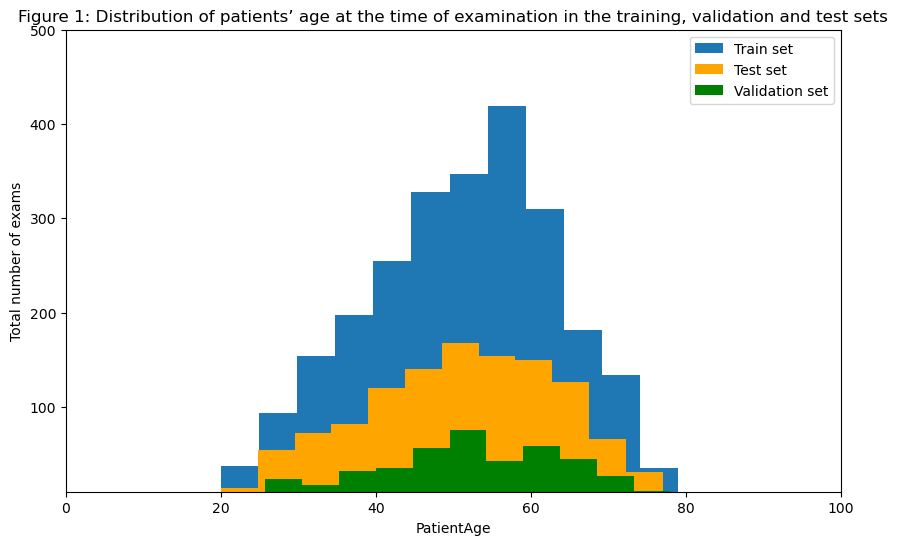

In [33]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10,6))
plt.hist(train_inds['patientAge'], bins = 12, label="Train set")
plt.hist(test_inds['patientAge'], bins = 12,  color='orange', label="Test set")
plt.hist(val_inds['patientAge'], bins = 12, color='green', label="Validation set")
plt.ylim(10, 500)
plt.xlim(0, 100)
plt.xlabel("PatientAge")
plt.ylabel("Total number of exams")
plt.title('Figure 1: Distribution of patients’ age at the time of examination in the training, validation and test sets')
plt.legend()
plt.show() 

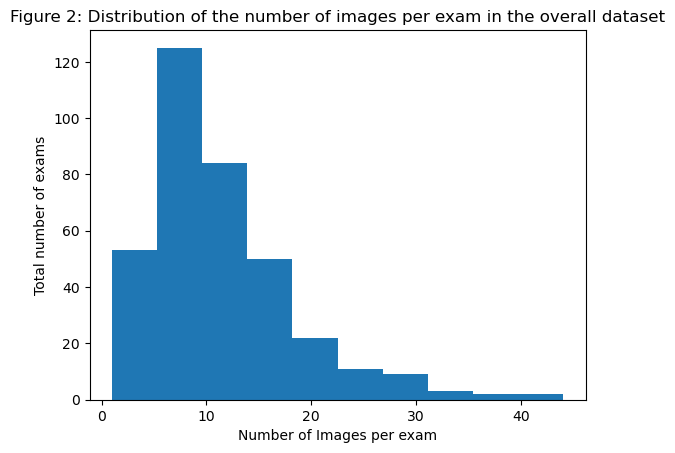

In [34]:
image_count = merged_df.groupby(['patient_id']).nunique()['image_id']
image_count
plt.hist(image_count)
plt.xlabel('Number of Images per exam')
plt.ylabel('Total number of exams')
plt.title('Figure 2: Distribution of the number of images per exam in the overall dataset')
plt.show()
#This code creates a histogram of the number of images per patient, with the number of images on the x-axis and the number of patients on th

Breast cancer labels: In the total of 4099 images, the left breast ultrasound images are 1371, the right breast ultrasound images are 1877, and the remaining are bilateral 850, which means the ultrasound images refer to both sides. Amongst these, 1584 are biopsy confirmed malignant, and 2024 are biopsy-confirmed benign.

In [35]:
##Counting the ultrasound images Left, Right and bilateral
##From original dataset
right_breast = merged_df['study_descriptions'].str.contains('right').sum()
left_breast = merged_df['study_descriptions'].str.contains('left').sum()
bilateral_count = merged_df['study_descriptions'].str.contains('bilateral').sum()
##From original dataset
biopsy_malignant = merged_df['biopsy'].str.contains('malignant').sum()
biopsy_benign = merged_df['biopsy'].str.contains('benign').sum()

##Counting the ultrasound images Left, Right and bilateral
##From train dataset
train_right_breast = train_inds['study_descriptions'].str.contains('right').sum()
train_left_breast = train_inds['study_descriptions'].str.contains('left').sum()
train_bilateral_count = train_inds['study_descriptions'].str.contains('bilateral').sum()
##From original dataset
train_biopsy_malignant = train_inds['biopsy'].str.contains('malignant').sum()
train_biopsy_benign = train_inds['biopsy'].str.contains('benign').sum()


##Counting the ultrasound images Left, Right and bilateral
##From test dataset
test_right_breast = test_inds['study_descriptions'].str.contains('right').sum()
test_left_breast = test_inds['study_descriptions'].str.contains('left').sum()
test_bilateral_count = test_inds['study_descriptions'].str.contains('bilateral').sum()
##From tet dataset
test_biopsy_malignant = test_inds['biopsy'].str.contains('malignant').sum()
test_biopsy_benign = test_inds['biopsy'].str.contains('benign').sum()

##Counting the ultrasound images Left, Right and bilateral
##From validate dataset
validate_right_breast = val_inds['study_descriptions'].str.contains('right').sum()
validate_left_breast = val_inds['study_descriptions'].str.contains('left').sum()
validate_bilateral_count = val_inds['study_descriptions'].str.contains('bilateral').sum()
##From validate dataset
validate_biopsy_malignant = val_inds['biopsy'].str.contains('malignant').sum()
validate_biopsy_benign = val_inds['biopsy'].str.contains('benign').sum()



train_data = {'Left_Breast': train_right_breast,
       'Right_Breast': train_left_breast,
       'Bilateral': train_bilateral_count,
       'Biopsy_Malignant': train_biopsy_malignant,
       'Biopsy_Benign':train_biopsy_benign }
train_df = pd.DataFrame(train_data, index=[0])


test_data = {'Left_Breast': test_right_breast,
       'Right_Breast': test_left_breast,
       'Bilateral': test_bilateral_count,
       'Biopsy_Malignant': test_biopsy_malignant,
       'Biopsy_Benign':test_biopsy_benign}
test_df = pd.DataFrame(test_data, index=[0])

validate_data = {'Left_Breast': validate_right_breast,
       'Right_Breast': validate_left_breast,
       'Bilateral': validate_bilateral_count,
        'Biopsy_Malignant': validate_biopsy_malignant,
       'Biopsy_Benign':validate_biopsy_benign}
validate_df = pd.DataFrame(validate_data, index=[0])

result = pd.concat([train_df, test_df, validate_df])
result.index = ['Train', 'Test', 'Validate']
result.loc['Overall'] = result.sum(axis=0)
print("Table 2: Distribution of malignant and benign findings along with the right, left and bilateral ultrasounds for the train, test, and validation sets")
result

Table 2: Distribution of malignant and benign findings along with the right, left and bilateral ultrasounds for the train, test, and validation sets


,Left_Breast,Right_Breast,Bilateral,Biopsy_Malignant,Biopsy_Benign
Train,891,1074,468,940,1316
Test,356,567,254,426,626
Validate,124,236,70,218,165
Overall,1371,1877,792,1584,2107


BI-RADS risk assessment and mammographic breast density labels: The radiologist allocate the BI-RADS risk assessment labels. It indicates suspicious of malignancy. Mammographic results include the visual evaluation of the breast density ranging from extremely fatty to extremely dense breast. The BI-RADS risk assessment and mammographic density labels are extracted from the ultrasound and mammographic reports.

In [36]:
count0 = merged_df['birads'].str.contains('0').sum()
count1 = merged_df['birads'].str.contains('1').sum()
count2 = merged_df['birads'].str.contains('2').sum()
count3 = merged_df['birads'].str.contains('3').sum()
count4A = merged_df['birads'].str.contains('4A').sum()
count4B = merged_df['birads'].str.contains('4B').sum()
count4C = merged_df['birads'].str.contains('4C').sum()
count5 = merged_df['birads'].str.contains('5').sum()
count6= merged_df['birads'].str.contains('6').sum()
count1000 = merged_df['birads'].str.contains('1000').sum()
count1002 = merged_df['birads'].str.contains('1002').sum()
unknown = count1000 + count1002
final_counts = [count0, count1, count2, count3, count4A, count4B, count4C, count5, unknown ]
overall1 = pd.DataFrame({'overall': final_counts})
overall1.index = [0,1,2,3,'4A','4B','4C',5, 'unknown']
overall1.index.name = 'BI-RADS risk assesment'
overall1['percentage'] = (overall1['overall'] / overall1['overall'].sum() * 100).round(2)
# Combine the count and percentage into one column
overall1['Overall'] = overall1['overall'].astype(str) + ' (' + overall1['percentage'].astype(str) + '%)'
# Drop the count and percentage columns
overall1.drop(['overall', 'percentage'], axis=1, inplace=True)


#training set

count0 = train_inds['birads'].str.contains('0').sum()
count1 = train_inds['birads'].str.contains('1').sum()
count2 = train_inds['birads'].str.contains('2').sum()
count3 = train_inds['birads'].str.contains('3').sum()
count4A = train_inds['birads'].str.contains('4A').sum()
count4B = train_inds['birads'].str.contains('4B').sum()
count4C = train_inds['birads'].str.contains('4C').sum()
count5 = train_inds['birads'].str.contains('5').sum()
count6= train_inds['birads'].str.contains('6').sum()
count1000 = train_inds['birads'].str.contains('1000').sum()
count1002 = train_inds['birads'].str.contains('1002').sum()
unknown = count1000 + count1002
final_counts = [count0, count1, count2, count3, count4A, count4B, count4C, count5, unknown ]
train1 = pd.DataFrame({'train': final_counts})
train1.index = [0,1,2,3,'4A','4B','4C',5, 'unknown']
train1.index.name = 'BI-RADS risk assesment'
train1['percentage'] = (train1['train'] / train1['train'].sum() * 100).round(2)
# Combine the count and percentage into one column
train1['Training set'] = train1['train'].astype(str) + ' (' + train1['percentage'].astype(str) + '%)'
# Drop the count and percentage columns
train1.drop(['train', 'percentage'], axis=1, inplace=True)


#test set

count0 = test_inds['birads'].str.contains('0').sum()
count1 = test_inds['birads'].str.contains('1').sum()
count2 = test_inds['birads'].str.contains('2').sum()
count3 = test_inds['birads'].str.contains('3').sum()
count4A = test_inds['birads'].str.contains('4A').sum()
count4B = test_inds['birads'].str.contains('4B').sum()
count4C = test_inds['birads'].str.contains('4C').sum()
count5 = test_inds['birads'].str.contains('5').sum()
count6= test_inds['birads'].str.contains('6').sum()
count1000 = test_inds['birads'].str.contains('1000').sum()
count1002 = test_inds['birads'].str.contains('1002').sum()
unknown = count1000 + count1002
final_counts = [count0, count1, count2, count3, count4A, count4B, count4C, count5, unknown ]
test1 = pd.DataFrame({'test': final_counts})
test1.index = [0,1,2,3,'4A','4B','4C',5, 'unknown']
test1.index.name = 'BI-RADS risk assesment'
test1['percentage'] = (test1['test'] / test1['test'].sum() * 100).round(2)
# Combine the count and percentage into one column
test1['Test set'] = test1['test'].astype(str) + ' (' + test1['percentage'].astype(str) + '%)'
# Drop the count and percentage columns
test1.drop(['test', 'percentage'], axis=1, inplace=True)


#validation set

count0 = val_inds['birads'].str.contains('0').sum()
count1 = val_inds['birads'].str.contains('1').sum()
count2 = val_inds['birads'].str.contains('2').sum()
count3 = val_inds['birads'].str.contains('3').sum()
count4A = val_inds['birads'].str.contains('4A').sum()
count4B = val_inds['birads'].str.contains('4B').sum()
count4C = val_inds['birads'].str.contains('4C').sum()
count5 = val_inds['birads'].str.contains('5').sum()
#count6= val_inds['birads'].str.contains('6').sum()
count1000 = val_inds['birads'].str.contains('1000').sum()
count1002 = val_inds['birads'].str.contains('1002').sum()
unknown = count1000 + count1002
final_counts = [count0, count1, count2, count3, count4A, count4B, count4C, count5, unknown ]
validate1 = pd.DataFrame({'validate': final_counts})
validate1.index = [0,1,2,3,'4A','4B','4C',5, 'unknown']
validate1.index.name = 'BI-RADS risk assesment'
validate1['percentage'] = (validate1['validate'] / validate1['validate'].sum() * 100).round(2)
# Combine the count and percentage into one column
validate1['Validatation set'] = validate1['validate'].astype(str) + ' (' + validate1['percentage'].astype(str) + '%)'
# Drop the count and percentage columns
validate1.drop(['validate', 'percentage'], axis=1, inplace=True)

Birads = pd.concat([train1, test1, validate1, overall1], axis = 1)
print("Table 3: Distribution of BI-RADS risk assessment labels. BI-RADS risk assessment labels were extracted from the patient's ultrasound report. 'Unknown' indicates exams with missing or ambiguous information")
Birads

Table 3: Distribution of BI-RADS risk assessment labels. BI-RADS risk assessment labels were extracted from the patient's ultrasound report. 'Unknown' indicates exams with missing or ambiguous information


,Training set,Test set,Validatation set,Overall
BI-RADS risk assesment,,,,
0,9 (0.38%),31 (2.47%),5 (1.22%),45 (1.11%)
1,17 (0.72%),47 (3.75%),0 (0.0%),64 (1.58%)
2,44 (1.85%),42 (3.35%),0 (0.0%),86 (2.13%)
3,284 (11.95%),101 (8.05%),8 (1.96%),393 (9.73%)
4A,812 (34.16%),430 (34.29%),180 (44.01%),1422 (35.2%)
4B,424 (17.84%),234 (18.66%),17 (4.16%),675 (16.71%)
4C,410 (17.25%),164 (13.08%),114 (27.87%),688 (17.03%)
5,377 (15.86%),174 (13.88%),85 (20.78%),636 (15.74%)
unknown,0 (0.0%),31 (2.47%),0 (0.0%),31 (0.77%)


In [32]:
countA = merged_df['mammographicBD'].str.contains('A').sum()
countB = merged_df['mammographicBD'].str.contains('B').sum()
countC = merged_df['mammographicBD'].str.contains('C').sum()
countD = merged_df['mammographicBD'].str.contains('D').sum()
final_counts = [countA, countB, countC, countD]
overall2 = pd.DataFrame({'overall': final_counts})
overall2.index = ['A (breasts are almost entirely fatty)','B (scattered areas of fibroglandular density)', 'C (breasts are heterogeneously dense)', 'D (the breasts are extremely dense)']
overall2.index.name = 'Mammographic breast density'
overall2['percentage'] = (overall2['overall'] / overall2['overall'].sum() * 100).round(2)
# Combine the count and percentage into one column
overall2['Overall'] = overall2['overall'].astype(str) + ' (' + overall2['percentage'].astype(str) + '%)'
# Drop the count and percentage columns
overall2.drop(['overall', 'percentage'], axis=1, inplace=True)
overall2

##train set
countA = train_inds['mammographicBD'].str.contains('A').sum()
countB = train_inds['mammographicBD'].str.contains('B').sum()
countC = train_inds['mammographicBD'].str.contains('C').sum()
countD = train_inds['mammographicBD'].str.contains('D').sum()
final_counts = [countA, countB, countC, countD]
train2 = pd.DataFrame({'train': final_counts})
train2.index = ['A (breasts are almost entirely fatty)','B (scattered areas of fibroglandular density)', 'C (breasts are heterogeneously dense)', 'D (the breasts are extremely dense)']
train2.index.name = 'Mammographic breast density'
train2['percentage'] = (train2['train'] / train2['train'].sum() * 100).round(2)
# Combine the count and percentage into one column
train2['Training set'] = train2['train'].astype(str) + ' (' + train2['percentage'].astype(str) + '%)'
# Drop the count and percentage columns
train2.drop(['train', 'percentage'], axis=1, inplace=True)

##test set
countA = test_inds['mammographicBD'].str.contains('A').sum()
countB = test_inds['mammographicBD'].str.contains('B').sum()
countC = test_inds['mammographicBD'].str.contains('C').sum()
countD = test_inds['mammographicBD'].str.contains('D').sum()
final_counts = [countA, countB, countC, countD]
test2 = pd.DataFrame({'test': final_counts})
test2.index = ['A (breasts are almost entirely fatty)','B (scattered areas of fibroglandular density)', 'C (breasts are heterogeneously dense)', 'D (the breasts are extremely dense)']
test2.index.name = 'Mammographic breast density'
test2['percentage'] = (test2['test'] / test2['test'].sum() * 100).round(2)
# Combine the count and percentage into one column
test2['Test set'] = test2['test'].astype(str) + ' (' + test2['percentage'].astype(str) + '%)'
# Drop the count and percentage columns
test2.drop(['test', 'percentage'], axis=1, inplace=True)

##validation set
countA = val_inds['mammographicBD'].str.contains('A').sum()
countB = val_inds['mammographicBD'].str.contains('B').sum()
countC = val_inds['mammographicBD'].str.contains('C').sum()
countD = val_inds['mammographicBD'].str.contains('D').sum()
final_counts = [countA, countB, countC, countD]
validate2 = pd.DataFrame({'validate': final_counts})
validate2.index = ['A (breasts are almost entirely fatty)','B (scattered areas of fibroglandular density)', 'C (breasts are heterogeneously dense)', 'D (the breasts are extremely dense)']
validate2.index.name = 'Mammographic breast density'
validate2['percentage'] = (validate2['validate'] / validate2['validate'].sum() * 100).round(2)
# Combine the count and percentage into one column
validate2['Validation set'] = validate2['validate'].astype(str) + ' (' + validate2['percentage'].astype(str) + '%)'
# Drop the count and percentage columns
validate2.drop(['validate', 'percentage'], axis=1, inplace=True)


Mdensity = pd.concat([train2, test2, validate2, overall2], axis = 1)
print("Table 4: Distribution of Mammographic breast density labels. Mammographic density labels are extracted from the patient's mammogram report.")
Mdensity

Table 4: Distribution of Mammographic breast density labels. Mammographic density labels are extracted from the patient's mammogram report.


,Training set,Test set,Validation set,Overall
Mammographic breast density,,,,
A (breasts are almost entirely fatty),668 (26.82%),289 (24.55%),114 (26.51%),1071 (26.13%)
B (scattered areas of fibroglandular density),605 (24.29%),297 (25.23%),113 (26.28%),1015 (24.77%)
C (breasts are heterogeneously dense),602 (24.17%),280 (23.79%),109 (25.35%),991 (24.18%)
D (the breasts are extremely dense),616 (24.73%),311 (26.42%),94 (21.86%),1021 (24.91%)


Scanner information: We have the extracted information about the ultrasound system used to capture the image using the softwareVersion attribute in the DICOM file.

In [37]:
#overall dataset
overall_mt = merged_df['machineType'].value_counts()
overall_mt1 = overall_mt.reset_index().set_index('machineType')

# Rename the columns
overall_mt1.columns = ['Overall']

#training set
train_mt = train_inds['machineType'].value_counts()
train_mt1 = train_mt.reset_index().set_index('machineType')

# Rename the columns
train_mt1.columns = ['Training Set']

#training set
test_mt = test_inds['machineType'].value_counts()
test_mt1 = test_mt.reset_index().set_index('machineType')

# Rename the columns
test_mt1.columns = ['Test Set']

#training set
validation_mt = val_inds['machineType'].value_counts()
validation_mt1 = validation_mt.reset_index().set_index('machineType')

# Rename the columns
validation_mt1.columns = ['Validation Set']

machines = pd.concat([train_mt1, test_mt1, validation_mt1, overall_mt1], axis = 1)
print("Table 5: Distribution of types of ultrasound machines used to collect the exams in the training, validation and test sets.")
machines.rename_axis("Devices")


Table 5: Distribution of types of ultrasound machines used to collect the exams in the training, validation and test sets.


,Training Set,Test Set,Validation Set,Overall
Devices,,,,
LOGIQ5,383,175,63,621
LOGIQ7,382,184,53,619
S3000,364,180,60,604
S1000,359,155,76,590
Affiniti,341,152,62,555
Xario,335,159,61,555
LOGIQ9,327,172,55,554


### PyTorch Downloaders

In [38]:
# After splitting

# Get the indices for each set
train_inds = custom_dataset.img_labels.index[custom_dataset.img_labels['patient_id'].isin(train_ids)].tolist()
val_inds = custom_dataset.img_labels.index[custom_dataset.img_labels['patient_id'].isin(val_ids)].tolist()
test_inds = custom_dataset.img_labels.index[custom_dataset.img_labels['patient_id'].isin(test_ids)].tolist()

# Create the datasets
train_data = Subset(custom_dataset, train_inds)
val_data = Subset(custom_dataset, val_inds)
test_data = Subset(custom_dataset, test_inds)

# Add a new column 'split' to the DataFrame [contains- 0,1,2 lables for train, val, test]
custom_dataset.img_labels['split'] = -1  # Initialize with -1 for all samples
custom_dataset.img_labels.loc[train_inds, 'split'] = 0  # Assign 0 for train samples
custom_dataset.img_labels.loc[val_inds, 'split'] = 1  # Assign 1 for val samples
custom_dataset.img_labels.loc[test_inds, 'split'] = 2  # Assign 2 for test samples


train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 224, 224])
Labels batch shape: torch.Size([64])


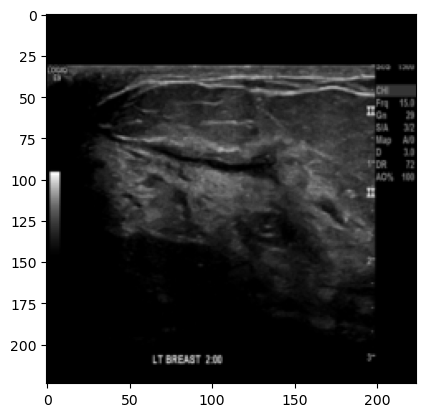

Label: 1


array(['malignant', 'benign', 'unknown'], dtype=object)

In [123]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[13].squeeze()
label = train_labels[13]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

custom_dataset.class_names

### Classification model- ResNet-50. A 50-layer convolutional neural network

We filtered the doppler images and the unknown biopsies from the dataset as per client requirements.

In [134]:
filter_rgb_unknown = merged_df[(merged_df['image_type'] != 'RGB') & (merged_df['biopsy'] != 'unknown')]
filter_rgb_unknown.columns

Index(['image_id', 'patient_id', 'biopsy', 'birads', 'filename',
       'patient_size', 'patient_weight', 'us_x0', 'us_y0', 'us_x1', 'us_y1',
       'delta_x', 'delta_y', 'image_type', 'study_date', 'patientAge',
       'mammographicBD', 'machineType', 'study_descriptions', 'image_filename',
       'text', 'cleaned_text', 'Scanning_Area', 'Location', 'TIME',
       'Distance FN'],
      dtype='object')

In [136]:
# set all entries to False
filter_rgb_unknown.loc[:,'is_valid'] = False

In [137]:
#randomly sample a set of patient IDs
val_ids = np.random.choice(filter_rgb_unknown['patient_id'].unique(), size=round(len(filter_rgb_unknown['patient_id'].unique())*0.3), replace=False)

In [138]:
# set the corresponding entries to True for those patients
filter_rgb_unknown.loc[filter_rgb_unknown['patient_id'].isin(val_ids), 'is_valid'] = True

In [139]:
##divide into train and testset
##dividining in train and validation set
train_ids, val_ids = train_test_split(filter_rgb_unknown['patient_id'].unique(), test_size=0.3, random_state=42)

# print the percentage of samples in train and validation set
print(f"Train samples: {len(filter_rgb_unknown[filter_rgb_unknown['is_valid']==False])} ({len(filter_rgb_unknown[filter_rgb_unknown['is_valid']==False])/len(filter_rgb_unknown)*100:.2f}%)")
print(f"Validation samples: {len(filter_rgb_unknown[filter_rgb_unknown['is_valid']==True])} ({len(filter_rgb_unknown[filter_rgb_unknown['is_valid']==True])/len(filter_rgb_unknown)*100:.2f}%)")


Train samples: 2153 (69.63%)
Validation samples: 939 (30.37%)


### ResNet 18 model

In [140]:
##splitting on patient_id
from fastai.vision.all import *

# Define path to images folder
path = Path('C:/Users/prana/image')

# Define your transforms
tfms = aug_transforms()

# Create your DataBlock with ColSplitter
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=ColSplitter('is_valid'),
                   get_x= lambda row: path/row['image_filename'],
                   get_y=ColReader('biopsy'),
                   item_tfms=Resize(128),
                   batch_tfms=tfms)

# Create your DataLoaders
dls = dblock.dataloaders(filter_rgb_unknown, bs=64)

# Define your model architecture
model = resnet18

# Create the learner
learn = cnn_learner(dls, model, metrics=accuracy, n_out=3)

# Train the model
learn.fine_tune(25)


C:\Users\prana\anaconda3\lib\site-packages\fastai\vision\learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
C:\Users\prana\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\prana\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,1.820251,1.239052,0.478168,03:44


epoch,train_loss,valid_loss,accuracy,time
0,1.367842,0.997450,0.594249,04:27
1,1.323570,0.939385,0.623003,04:25
2,1.204621,0.891302,0.608094,04:33
3,1.144106,0.862510,0.646432,04:24
4,1.042814,0.831332,0.630458,03:16
5,0.918418,0.850604,0.646432,03:47
6,0.830621,0.899849,0.641108,03:15
7,0.735550,0.805332,0.640043,02:50
8,0.655295,0.808756,0.651757,02:49
9,0.584109,0.752335,0.664537,03:18


### ResNet50 model

In [141]:
##splitting on patient_id
from fastai.vision.all import *

# Define path to images folder
path = Path('C:/Users/prana/image')

# Define your transforms
tfms = aug_transforms()

# Create your DataBlock with ColSplitter
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=ColSplitter('is_valid'),
                   get_x= lambda row: path/row['image_filename'],
                   get_y=ColReader('biopsy'),
                   item_tfms=Resize(128),
                   batch_tfms=tfms)

# Create your DataLoaders
dls = dblock.dataloaders(filter_rgb_unknown, bs=64)

# Define your model architecture
model = resnet50

# Create the learner
learn = cnn_learner(dls, model, metrics=accuracy, n_out=3)

# Train the model
learn.fine_tune(25)


C:\Users\prana\anaconda3\lib\site-packages\fastai\vision\learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
C:\Users\prana\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\prana\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy,time
0,1.913533,4.009449,0.351438,04:59


epoch,train_loss,valid_loss,accuracy,time
0,1.599628,2.021068,0.418530,06:22
1,1.366140,1.233331,0.550586,06:08
2,1.199834,1.207434,0.585729,05:59
3,1.085202,1.194145,0.571885,05:57
4,0.983130,0.930245,0.652822,05:59
5,0.861934,1.014475,0.621938,06:01
6,0.746073,0.768828,0.665602,05:56
7,0.662834,1.254979,0.628328,05:55
8,0.569185,0.923207,0.633653,05:52
9,0.498066,0.928279,0.646432,05:55


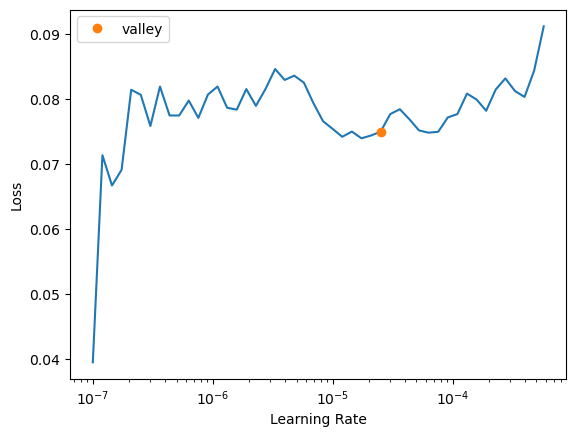

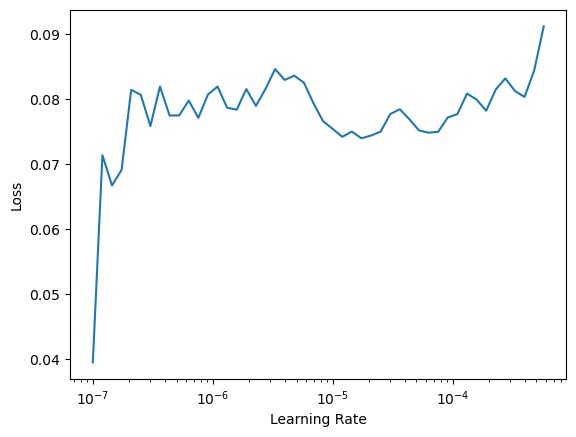

In [52]:
##Learning Rate Finder Plot: This plot shows the learning rate that gives the fastest decrease in the loss function 
#during training. You can create this plot using the lr_find() method of the learner object.

learn.lr_find()
learn.recorder.plot_lr_find()

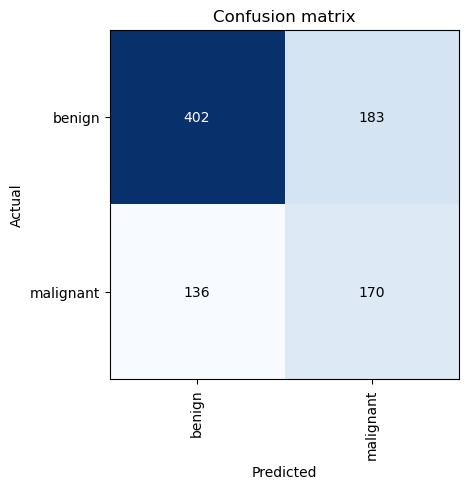

In [51]:
## This plot shows the distribution of predicted and actual labels for each class in your dataset. You can create this plot
#using the plot_confusion_matrix() method of the interpreter object.
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()